# Grand Tour 

- Rules: Draw a single closed loop in the grid which visits all grid dots exactly once and uses all given line segments

> To be converted to SCIP Solver...

In [1]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import gurobipy as grb
import numpy as np
import os
from matplotlib.pyplot import MultipleLocator
from matplotlib.patches import Rectangle
# Defining the function to map decimal input to the corresponding sides being blackened
def blackened_sides(decimal_number):

    sides = ["T","L","B", "R"]
    # Convert the decimal number to 4-bit binary, padded with zeros if necessary
    binary_representation = format(decimal_number, '04b')
    blackened = [sides[i] for i in range(4) if binary_representation[i] == '1']
    return blackened

# Test the function with the input 7
if __name__ == "__main__":
    blackened_sides(7)


In [2]:
def readInstance(path):
    
    # 从测试案例中随机选取一个测试案例出来
    # file_name = f"../assets/data/GrandTourSolverdata/{path}{np.random.randint(1)+1}.txt"
    file_name = f"../assets/data/GrandTour/problems/{path}"

    m = 0
    n = 0
    grids = None
    print( f"READING FILE {file_name}" )
    if not os.path.isfile(file_name):
        print('File does not exist')
    else:
        # keys = ['m', 'n', 'w', 'p']
        # d = dict()
        
        with open(file_name) as file:
            firstline = file.readline().strip().split(" ")
            m = int(firstline[0])
            n = int(firstline[1])
            grids = [[0 for _ in range(n)] for _ in range(m)]

            for idx in range(m):
                line = file.readline().strip().split(" ")
                assert len(line) == n
                for j in range(n):
                    if line[j] not in ['-']:
                        grids[idx][j] = int(line[j])
    return m, n, grids

if __name__ == "__main__":
    data = "16_11x11.txt"
    m, n, grids = readInstance(data)
    print(m,n)
    print(grids)

READING FILE ../assets/data/GrandTour/problems/16_11x11.txt
11 11
[[0, 0, 2, 2, 8, 0, 2, 2, 8, 0, 0], [0, 1, 12, 8, 0, 1, 14, 8, 0, 1, 6], [0, 2, 0, 2, 0, 2, 8, 2, 0, 0, 8], [2, 8, 2, 8, 0, 8, 2, 8, 0, 0, 2], [10, 2, 8, 2, 0, 0, 10, 0, 1, 4, 8], [8, 8, 0, 8, 2, 1, 12, 0, 1, 4, 0], [2, 0, 0, 2, 8, 2, 0, 0, 1, 4, 2], [8, 0, 2, 8, 0, 8, 0, 2, 0, 0, 8], [2, 0, 8, 3, 4, 0, 0, 9, 4, 0, 0], [8, 0, 1, 12, 1, 4, 0, 2, 1, 4, 0], [0, 0, 0, 0, 1, 4, 0, 9, 4, 0, 0]]


In [3]:
def GrandTourWithLazyCuts(m, n, grids):
    GrandTourSolver = grb.Model("GrandTour")
    x = dict()
    to_dict = dict()
    node_nums = (m + 1) * (n + 1)
    for i in range(m + 1):
        for j in range(n + 1):
            if j + 1 <= n:
                x[i * (n + 1) + j, i * (n + 1) + j + 1] = GrandTourSolver.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[{i * (n + 1) + j},{i * (n + 1) + j + 1}]"
                )
            if i < m:
                x[i * (n + 1) + j, (i + 1) * (n + 1) + j] = GrandTourSolver.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[{i * (n + 1)},{(i + 1) * (n + 1)}]"
                )
    print(f"ALL LINES (WITHOUT DUP) {len(x)}")
    GrandTourSolver.modelSense = grb.GRB.MINIMIZE
    GrandTourSolver.Params.lazyConstraints = 1
    GrandTourSolver.update()
    
    for (ori, dep) in x.keys():
        if ori not in to_dict:
            to_dict[ori] = [[ori, dep]]
        else:
            to_dict[ori].append([ori, dep])
        if dep not in to_dict:
            to_dict[dep] = [[ori, dep]]
        else:
            to_dict[dep].append([ori, dep])
    
    for i in range(node_nums):
        GrandTourSolver.addConstr(grb.quicksum(x[i, j] for (i, j) in to_dict[i]) == 2, name = f"BALANCE_{i}")
    for i in range(m):
        for j in range(n):
            if grids[i][j] == 0:
                continue
            edges = blackened_sides(grids[i][j])
            for edge in edges:
                if edge == 'L':
                    GrandTourSolver.addConstr(x[i * (n + 1) + j, (i + 1) * (n + 1) + j] == 1, name = f"L_{i}_{j}")
                if edge == "R":
                    GrandTourSolver.addConstr(x[i * (n + 1) + j + 1, (i + 1) * (n + 1) + j + 1 ] == 1, name = f"R_{i}_{j}")
                if edge == "B":
                    GrandTourSolver.addConstr(x[(i + 1) * (n + 1) + j, (i + 1) * (n + 1) + j + 1 ] == 1, name = f"B_{i}_{j}")
                if edge == "T":
                    GrandTourSolver.addConstr(x[i * (n + 1) + j, i * (n + 1) + j + 1 ] == 1, name = f"T_{i}_{j}")
                    
    def subtourelim(model, where):
        # 回调函数
        if (where == grb.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            # 从新的 MIP 解决方案中检索值。
            G = nx.Graph()
            nodes_appear = []
            for (i, j) in x.keys():
                if (x_sol[i, j] > 0.9):
                    if i not in nodes_appear:
                        nodes_appear.append(i)
                    if j not in nodes_appear:
                        nodes_appear.append(j)
                    G.add_edge(i, j, weight = 1)
            components = [list(c) for c in nx.connected_components(G)]
            # 获得当前图里所有的子环路
            print("The length is " + str(len(components)))
            for component in components:
                if (len(component) < len(nodes_appear)):
                    # 消除那些环路
                    print("Add cut")
                    model.cbLazy(grb.quicksum(x[i,j] for i in component \
                        for j in component if (i, j) in x.keys()) <= len(component) - 1)
                    
    GrandTourSolver._x = x
    GrandTourSolver.optimize(subtourelim)
    ofv = None
    seq = []
    arcs = []
    solType = None
    gap = None
    lb = None
    ub = None
    runtime = None
    if (GrandTourSolver.status == grb.GRB.status.OPTIMAL):
        solType = 'IP_Optimal'
        ofv = GrandTourSolver.getObjective().getValue()
        print(ofv)
        for i, j in x:
            if (x[i, j].x > 0.5):
                arcs.append([i, j])
        gap = 0
        lb = ofv
        ub = ofv
        runtime = GrandTourSolver.Runtime
    elif (GrandTourSolver.status == grb.GRB.status.TIME_LIMIT):
        solType = 'IP_TimeLimit'
        ofv = None
        seq = []
        gap = GrandTourSolver.MIPGap
        lb = GrandTourSolver.ObjBoundC
        ub = GrandTourSolver.ObjVal
        runtime = GrandTourSolver.Runtime


    
    return {
        "TotalCost": ofv,
        "runtime": runtime,
        "arcs": arcs
    }

if __name__ == "__main__":
    result = GrandTourWithLazyCuts(m, n, grids)
    print(result)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-29
ALL LINES (WITHOUT DUP) 264
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 230 rows, 264 columns and 614 nonzeros
Model fingerprint: 0x491a8935
Variable types: 0 continuous, 264 integer (264 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 183 rows and 175 columns
Presolve time: 0.00s
Presolved: 47 rows, 89 columns, 176 nonzeros
Variable types: 0 continuous, 89 integer (89 binary)
The length is 6
Add cut
Add cut
Add cut
Add cut
Add cut
Add cut

Root relaxation: objective 1.440000e+02, 60 iterations, 0.00 seconds (0.00 work units)
The length is 8
Add cut
Add cut


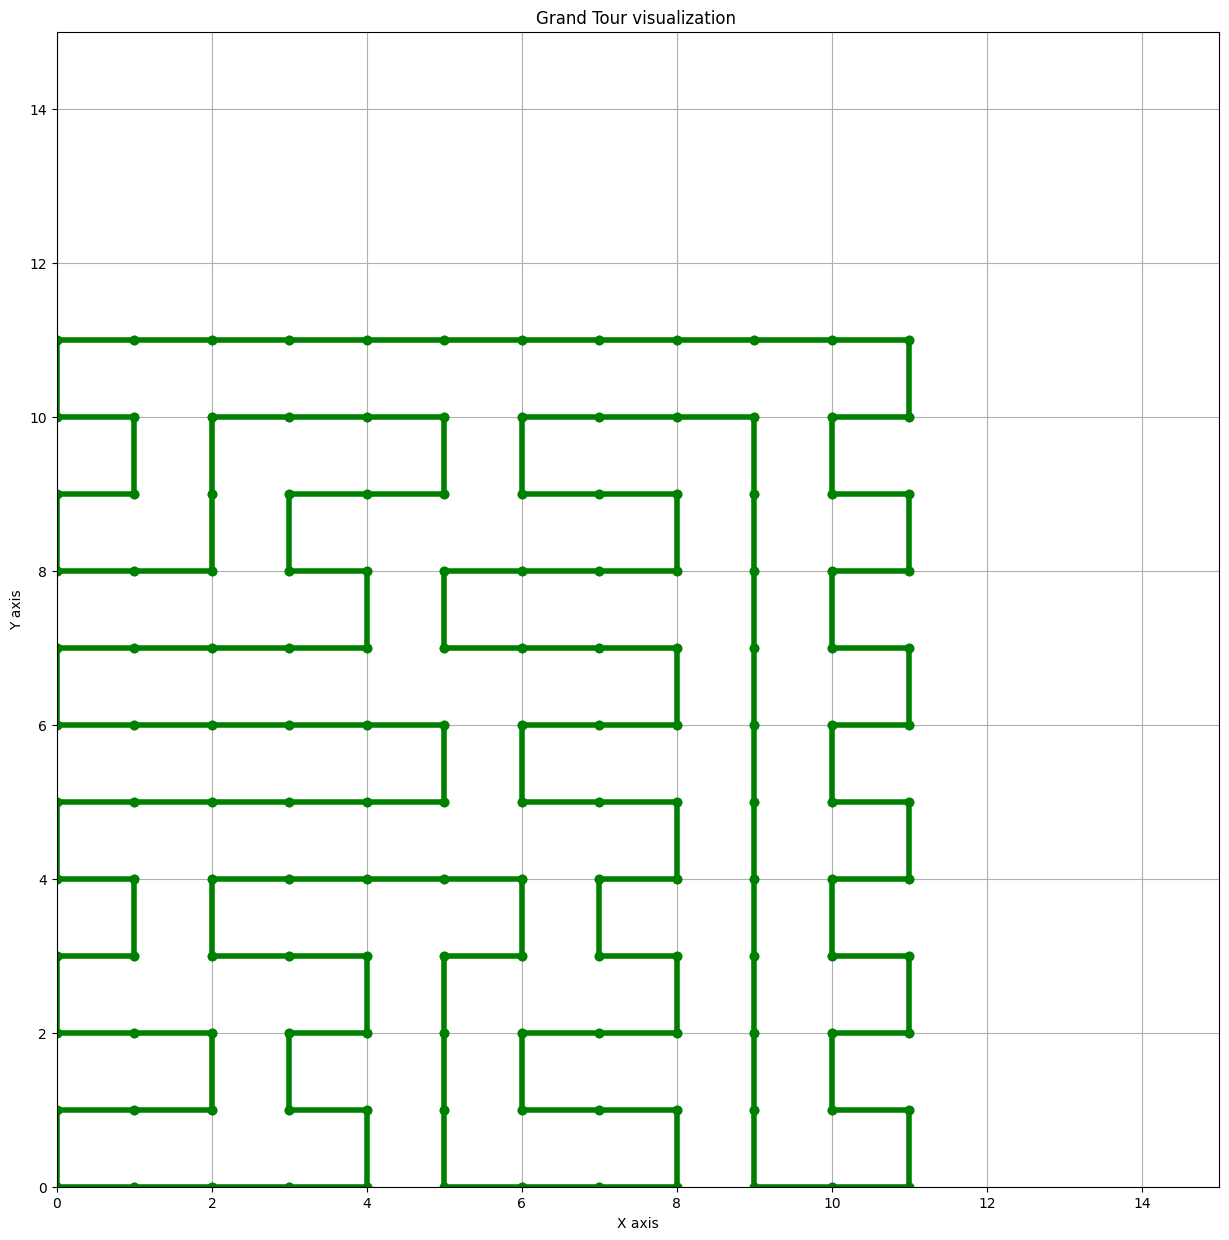

In [4]:
plt.figure(figsize=(15, 15))
for route in result['arcs']:
    
    begin, end = route[0], route[1]
    route_x, route_y = [], []
    route_x.append(begin % (n + 1))
    route_y.append(m - begin // (n + 1))
    
    route_x.append(end % (n + 1))
    route_y.append(m - end // (n + 1))
    # print(begin, end)

    plt.plot(route_x, route_y, 'go-', label='line 1', linewidth=4)


plt.xlim(0, 15)
plt.ylim(0, 15)

plt.title(f'Grand Tour visualization ')
plt.xlabel('X axis')
plt.ylabel('Y axis')
# 显示网格（可选）
plt.grid(True)
# 显示图形
plt.show()